In [1]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv('Data/AB_Test_Results.csv', sep=',')
data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [60]:
data.describe(include='all')

,USER_ID,VARIANT_NAME,REVENUE
count,10000.000000,10000,10000.000000
unique,NaN,2,NaN
top,NaN,variant,NaN
freq,NaN,5016,NaN
mean,4981.080200,NaN,0.099447
std,2890.590115,NaN,2.318529
min,2.000000,NaN,0.000000
25%,2468.750000,NaN,0.000000
50%,4962.000000,NaN,0.000000
75%,7511.500000,NaN,0.000000


In [62]:
data.select_dtypes('number').std() / data.select_dtypes('number').mean()

USER_ID     0.580314
REVENUE    23.314214
dtype: float64

<Axes: xlabel='REVENUE', ylabel='Count'>

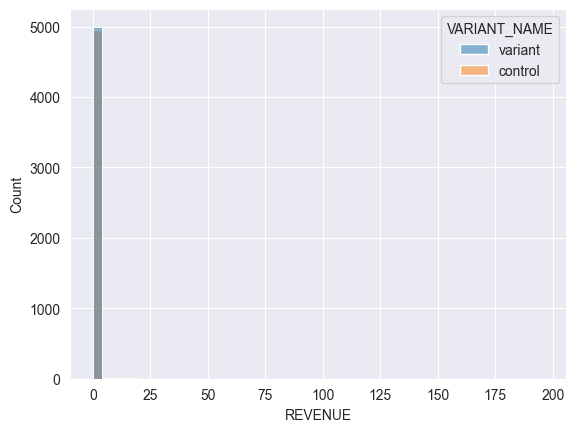

In [11]:
import seaborn as sns

sns.histplot(data=data, x='REVENUE', hue='VARIANT_NAME', bins=50)

<Axes: xlabel='REVENUE'>

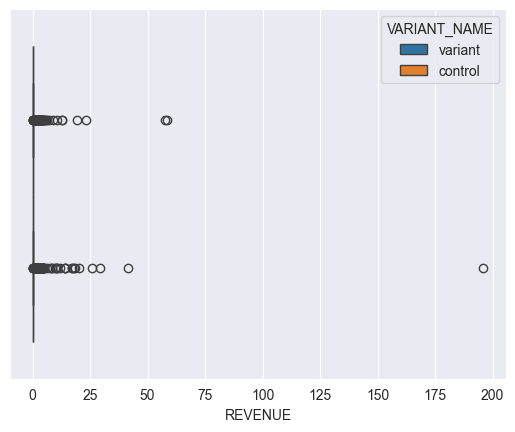

In [13]:
sns.boxplot(data=data, x='REVENUE', hue='VARIANT_NAME')

In [32]:
from scipy.stats import shapiro

shapiro(data[data['VARIANT_NAME'] == 'control'].REVENUE)

# Отвергаем нулевую гипотезу (данные распределены не нормально)

ShapiroResult(statistic=0.01833147442513483, pvalue=2.4983285100055776e-95)

In [31]:
shapiro(data[data['VARIANT_NAME'] == 'variant'].REVENUE)

# Отвергаем нулевую гипотезу (данные распределены не нормально)

C:\Users\merku\.virtualenvs\MachineLearning-x7kuzlXN\lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5016.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=0.027033073451830147, pvalue=2.7310104028899288e-95)

<Axes: ylabel='Frequency'>

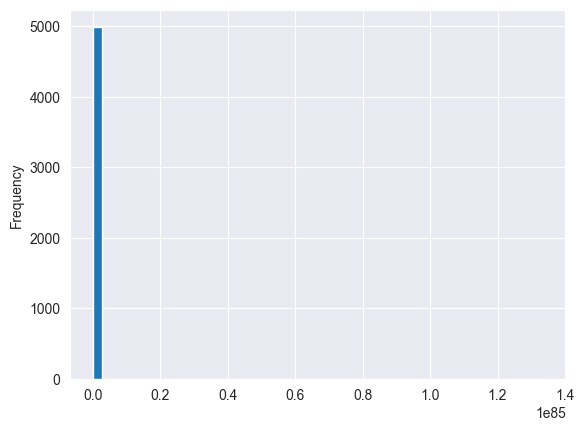

In [92]:
np.exp(data[data['VARIANT_NAME'] == 'control'].REVENUE).plot(kind='hist', bins=50)

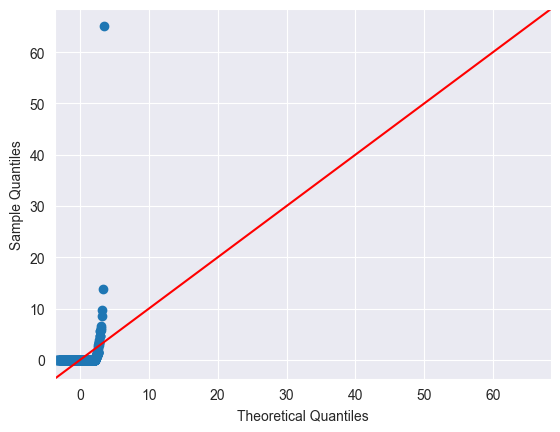

In [96]:
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt

sm.qqplot(data=(data[data['VARIANT_NAME'] == 'control'].REVENUE -
                data[data['VARIANT_NAME'] == 'control'].REVENUE.mean()) /
               data[data['VARIANT_NAME'] == 'control'].REVENUE.std(),
          dist=norm,
          line='45')
plt.show()

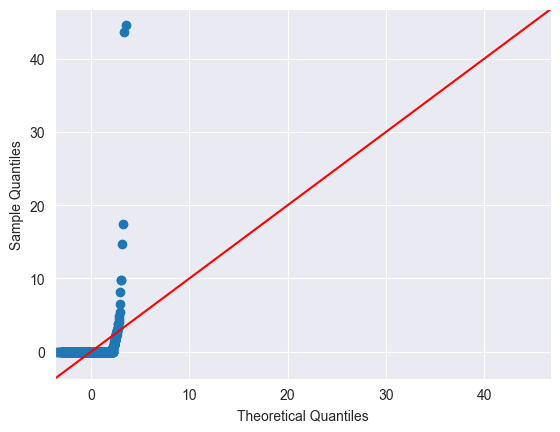

In [44]:
sm.qqplot(data=(data[data['VARIANT_NAME'] == 'variant'].REVENUE -
                data[data['VARIANT_NAME'] == 'variant'].REVENUE.mean()) /
               data[data['VARIANT_NAME'] == 'variant'].REVENUE.std(),
          dist=norm,
          line='45')
plt.show()

In [49]:
from scipy.stats import ttest_ind

ttest_ind(data[data['VARIANT_NAME'] == 'control'].REVENUE,
          data[data['VARIANT_NAME'] == 'variant'].REVENUE,
          equal_var=False,
          alternative='two-sided')

# Принимаем нулевую гипотезу (нет отличий между средними выборок)

TtestResult(statistic=1.268403803110966, pvalue=0.20469713432410774, df=6811.174610031575)

In [53]:
ttest_ind(a=(data[data['VARIANT_NAME'] == 'control'].REVENUE -
             data[data['VARIANT_NAME'] == 'control'].REVENUE.mean()) ** 2,

          b=(data[data['VARIANT_NAME'] == 'variant'].REVENUE -
             data[data['VARIANT_NAME'] == 'variant'].REVENUE.mean()) ** 2,

          equal_var=False,
          alternative='two-sided')

# Принимаем нулевую гипотезу (нет отличий между дисперсиями выборок)

TtestResult(statistic=0.9414216567820833, pvalue=0.34653308842647934, df=5136.878866956813)

In [58]:
from scipy.stats import levene

levene(data[data['VARIANT_NAME'] == 'control'].REVENUE,
       data[data['VARIANT_NAME'] == 'variant'].REVENUE,
       center='median')

# Принимаем нулевую гипотезу (нет отличий между дисперсиями выборок)

LeveneResult(statistic=1.6158565214488871, pvalue=0.2037000785338918)

In [23]:
from scipy.stats import mannwhitneyu

mannwhitneyu(data[data['VARIANT_NAME'] == 'control'].REVENUE,
             data[data['VARIANT_NAME'] == 'variant'].REVENUE)

# Принимаем нулевую гипотезу (распределение данных одинаково)

MannwhitneyuResult(statistic=12521564.0, pvalue=0.47825247965294926)

### Найдём доверительные интервалы через Bootstrap (scipy стоит доверять больше)

(0.016879500000000002, 0.509759, 0.12901284109149277)

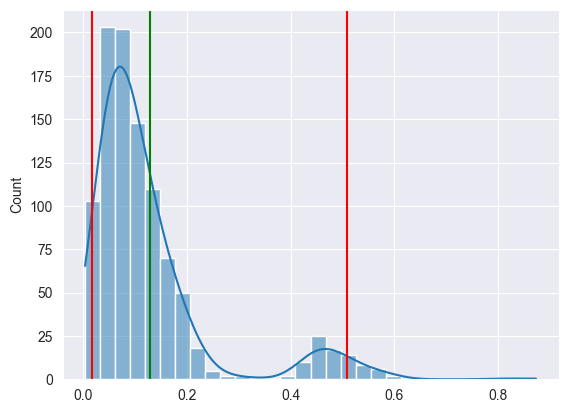

In [163]:
alpha = 0.05
n_iter = 1000
size = 500

means = []
for _ in range(n_iter):
    samples = np.random.choice(data[data['VARIANT_NAME'] == 'control'].REVENUE, size, replace=True)
    means.append(np.mean(samples))

a, b = np.quantile(means, q=[alpha / 2, 1 - alpha / 2])

sns.histplot(means, bins=30, kde=True)
plt.axvline(a, color='r')
plt.axvline(b, color='r')
plt.axvline(data[data['VARIANT_NAME'] == 'control'].REVENUE.mean(), color='g')

a, b, data[data['VARIANT_NAME'] == 'control'].REVENUE.mean()

ConfidenceInterval(low=0.06481189807383628, high=0.22626238964686995)

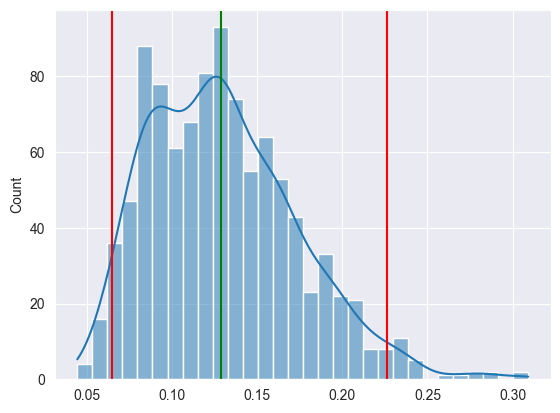

In [167]:
from scipy.stats import bootstrap

bs_data = bootstrap(data=(data[data['VARIANT_NAME'] == 'control'].REVENUE,),
                    statistic=np.mean,
                    n_resamples=1000,
                    batch=500,
                    method='percentile',
                    confidence_level=0.95)

sns.histplot(bs_data.bootstrap_distribution, bins=30, kde=True)
plt.axvline(bs_data.confidence_interval[0], color='r')
plt.axvline(bs_data.confidence_interval[1], color='r')
plt.axvline(data[data['VARIANT_NAME'] == 'control'].REVENUE.mean(), color='g')

bs_data.confidence_interval

(0.008674000000000001, 0.22358349999999994, 0.07006977671451356)

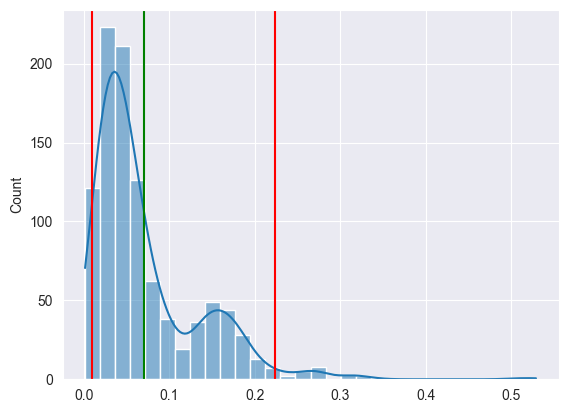

In [162]:
alpha = 0.05
n_iter = 1000
size = 500

means = []
for _ in range(n_iter):
    samples = np.random.choice(data[data['VARIANT_NAME'] == 'variant'].REVENUE, size, replace=True)
    means.append(np.mean(samples))

a, b = np.quantile(means, q=[alpha / 2, 1 - alpha / 2])

sns.histplot(means, bins=30, kde=True)
plt.axvline(a, color='r')
plt.axvline(b, color='r')
plt.axvline(data[data['VARIANT_NAME'] == 'variant'].REVENUE.mean(), color='g')

a, b, data[data['VARIANT_NAME'] == 'variant'].REVENUE.mean()

# Посчитали доверительный интервал для средних

ConfidenceInterval(low=0.03784878389154707, high=0.1115138058213716)

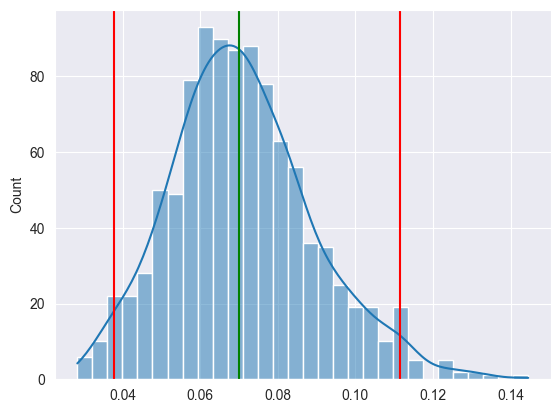

In [161]:
bs_data = bootstrap(data=(data[data['VARIANT_NAME'] == 'variant'].REVENUE,),
                    statistic=np.mean,
                    n_resamples=1000,
                    batch=500,
                    method='percentile',
                    confidence_level=0.95)

sns.histplot(bs_data.bootstrap_distribution, bins=30, kde=True)
plt.axvline(bs_data.confidence_interval[0], color='r')
plt.axvline(bs_data.confidence_interval[1], color='r')
plt.axvline(data[data['VARIANT_NAME'] == 'variant'].REVENUE.mean(), color='g')

bs_data.confidence_interval

### Найдём доверительные интервалы через распределение Стьюдента

In [210]:
from scipy.stats import t

alpha = 0.05

N = len(data[data['VARIANT_NAME'] == 'control'].REVENUE)
mean = np.mean(data[data['VARIANT_NAME'] == 'control'].REVENUE)
std = np.std(data[data['VARIANT_NAME'] == 'control'].REVENUE, ddof=1)  # поправка Бесселя
t_alpha2 = t.ppf(1 - alpha / 2, df=N - 1)

mean - t_alpha2 * std / N ** 0.5, mean + t_alpha2 * std / N ** 0.5

(0.04549606882676377, 0.21252961335622178)

In [219]:
std == (np.sum((data[data['VARIANT_NAME'] == 'control'].REVENUE -
                data[data['VARIANT_NAME'] == 'control'].REVENUE.mean()) ** 2) / (N - 1)) ** 0.5

True

In [206]:
alpha = 0.05

N = len(data[data['VARIANT_NAME'] == 'variant'].REVENUE)
mean = np.mean(data[data['VARIANT_NAME'] == 'variant'].REVENUE)
std = np.std(data[data['VARIANT_NAME'] == 'variant'].REVENUE, ddof=1)  # поправка Бесселя
t_alpha2 = t.ppf(1 - alpha / 2, df=N - 1)

mean - t_alpha2 * std / N ** 0.5, mean + t_alpha2 * std / N ** 0.5

(0.03367538440890519, 0.10646416902012193)

### Найдём доверительные интервалы через Нормальное распределение 
можем тк N > 30 (ЦПТ)

In [223]:
from scipy.stats import norm

alpha = 0.05

N = len(data[data['VARIANT_NAME'] == 'control'].REVENUE)
mean = np.mean(data[data['VARIANT_NAME'] == 'control'].REVENUE)
std = np.std(data[data['VARIANT_NAME'] == 'control'].REVENUE, ddof=1)  # поправка Бесселя
z_alpha2 = norm.ppf(1 - alpha / 2)

mean - z_alpha2 * std / N ** 0.5, mean + z_alpha2 * std / N ** 0.5

(0.04551635486622431, 0.21250932731676125)

In [224]:
alpha = 0.05

N = len(data[data['VARIANT_NAME'] == 'variant'].REVENUE)
mean = np.mean(data[data['VARIANT_NAME'] == 'variant'].REVENUE)
std = np.std(data[data['VARIANT_NAME'] == 'variant'].REVENUE, ddof=1)  # поправка Бесселя
z_alpha2 = norm.ppf(1 - alpha / 2)

mean - z_alpha2 * std / N ** 0.5, mean + z_alpha2 * std / N ** 0.5

(0.03368416811908986, 0.10645538530993726)